# 🌐 3D Sphere Attractor with SO(3) Regularization Demo

This notebook demonstrates training a 3D sphere attractor state space model with SO(3) rotational symmetry regularization.

Key adaptations from 2D ring attractor:
- **3D Sphere Dynamics**: `x' = x * (1 - ||x||)` in 3D space  
- **SO(3) Regularization**: Using rotation generators about x, y, z axes
- **3D Perturbations**: RBF-based noise in 3D
- **Reuses existing**: RegularizedSSM infrastructure

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# Setup
startupMode = 'dev'

if startupMode == 'dev':
    import sys
    sys.path.append('../..')  # add path for xfads root
    config_path = ''

In [105]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from pathlib import Path

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Timer
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Import our regularized SSM (existing)
from regularized_ssm import RegularizedSSM, RegularizedLightningSSM

# Import our new 3D sphere dynamics
from sphere_dynamics import PerturbedSphereAttractorRNN, create_so3_generators

## ⚙️ Initialize Configuration

In [106]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path=config_path, job_name="lds")
cfg = compose(config_name="config")

# Update config for 3D
cfg['n_latents'] = 3  # 3D sphere
cfg['n_latents_read'] = 3  # Read all 3 dimensions

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

Seed set to 1234


In [107]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

cfg['device'] = device
print(f"Using device: {device}")

cfg['n_epochs'] = 25
print(f"Training for {cfg['n_epochs']} epochs")
print(f"Latent dimensions: {cfg['n_latents']}")

Using device: cpu
Training for 25 epochs
Latent dimensions: 3


## 🌐 Generate 3D Sphere Attractor Data

In [108]:
# Data generation parameters
perturbation_magnitude = 0.1
n_trials = 1000
n_neurons = 150  # More neurons for 3D
n_time_bins = 75

# Create 3D sphere attractor dynamics
mean_fn = PerturbedSphereAttractorRNN(
    bin_sz=1e-1,
    perturbation_magnitude=perturbation_magnitude,
    grid_size=12,  # Reasonable size for 3D
    lengthscale=0.3
).to(cfg.device)

print(f"Created 3D sphere attractor with perturbation magnitude: {perturbation_magnitude}")

Created 3D sphere attractor with perturbation magnitude: 0.1


In [109]:
# Import our 3D sphere dynamics and visualization
from sphere_dynamics import PerturbedSphereAttractorRNN, create_so3_generators
from visualize_so3_fields import (
    plot_so3_generators_grid, 
    plot_2d_projections_so3,
    plot_streamlines_on_sphere,
    visualize_so3_vs_learned_dynamics
)

## 📈 Visualize 3D Sphere Trajectories

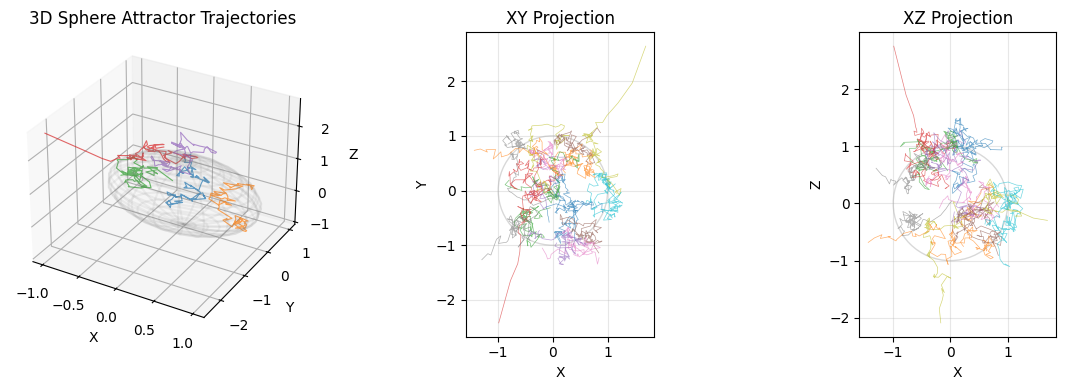

In [110]:
# 3D visualization of sphere trajectories
fig = plt.figure(figsize=(12, 4))

# Plot trajectories in 3D
ax1 = fig.add_subplot(131, projection='3d')
for i in range(5):  # Plot subset of trajectories
    traj = z[i, :, :].cpu()
    ax1.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, linewidth=0.8)

# Draw unit sphere wireframe for reference
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
sphere_x = np.outer(np.cos(u), np.sin(v))
sphere_y = np.outer(np.sin(u), np.sin(v))
sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(sphere_x, sphere_y, sphere_z, alpha=0.1, color='gray')

ax1.set_title("3D Sphere Attractor Trajectories")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# Show 2D projections
ax2 = fig.add_subplot(132)
for i in range(20):
    traj = z[i, :, :].cpu()
    ax2.plot(traj[:, 0], traj[:, 1], alpha=0.6, linewidth=0.5)
circle1 = plt.Circle((0, 0), 1, fill=False, color='gray', alpha=0.3)
ax2.add_patch(circle1)
ax2.set_title("XY Projection")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(133)
for i in range(20):
    traj = z[i, :, :].cpu()
    ax3.plot(traj[:, 0], traj[:, 2], alpha=0.6, linewidth=0.5)
circle2 = plt.Circle((0, 0), 1, fill=False, color='gray', alpha=0.3)
ax3.add_patch(circle2)
ax3.set_title("XZ Projection")
ax3.set_xlabel("X")
ax3.set_ylabel("Z")
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🌐 Visualizing SO(3) Generators


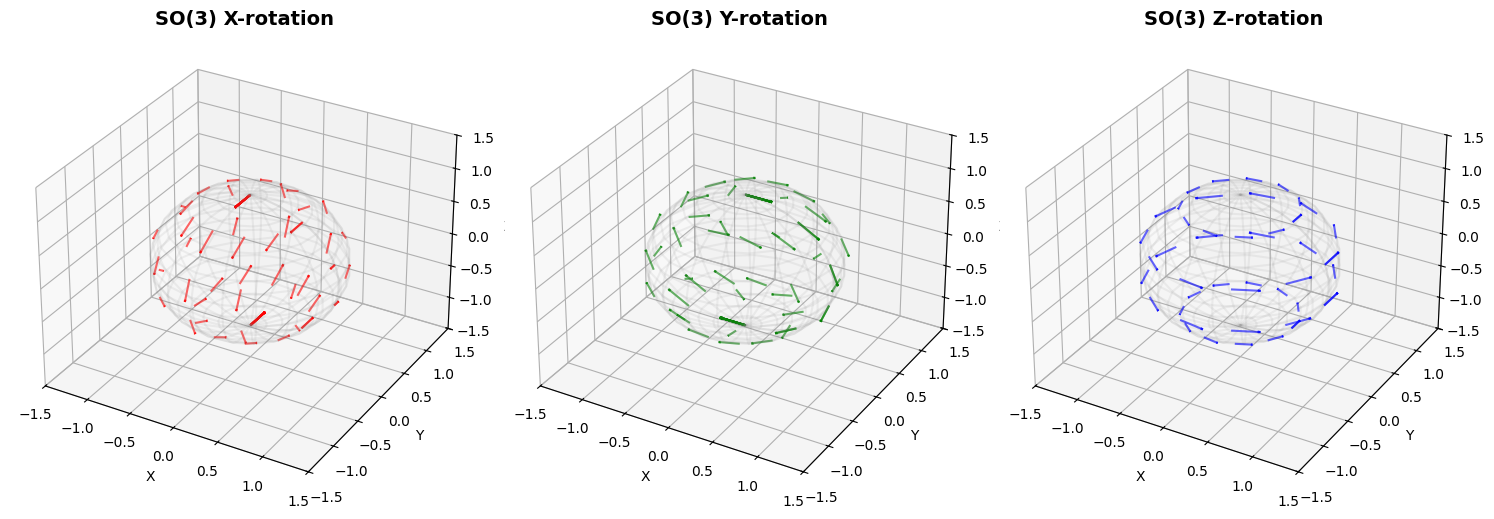

This shows the three infinitesimal rotation generators:
- Red (X-rotation): Rotation about X-axis
- Green (Y-rotation): Rotation about Y-axis
- Blue (Z-rotation): Rotation about Z-axis


In [111]:
# Visualize all SO(3) generators
print("🌐 Visualizing SO(3) Generators")
plot_so3_generators_grid()

print("This shows the three infinitesimal rotation generators:")
print("- Red (X-rotation): Rotation about X-axis")  
print("- Green (Y-rotation): Rotation about Y-axis")
print("- Blue (Z-rotation): Rotation about Z-axis")

📊 2D Projections of Z-rotation Generator


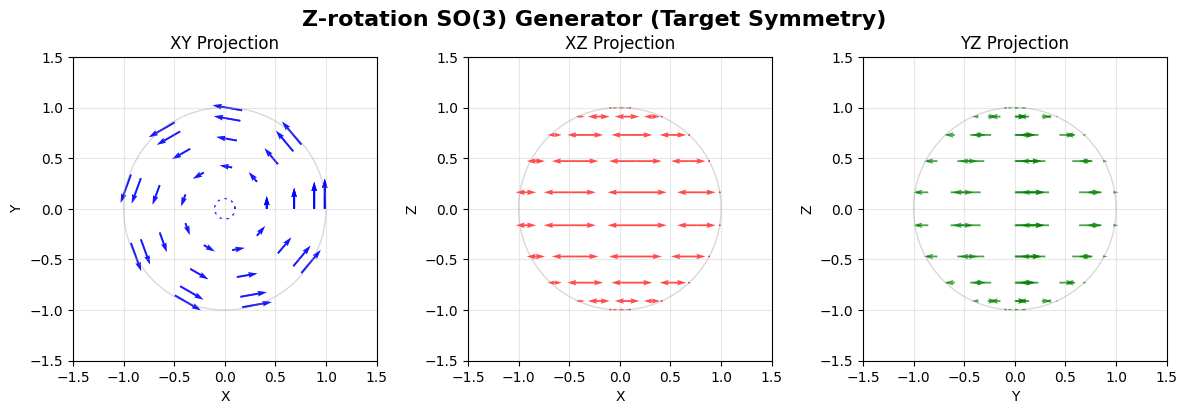

📈 Streamlines showing flow patterns


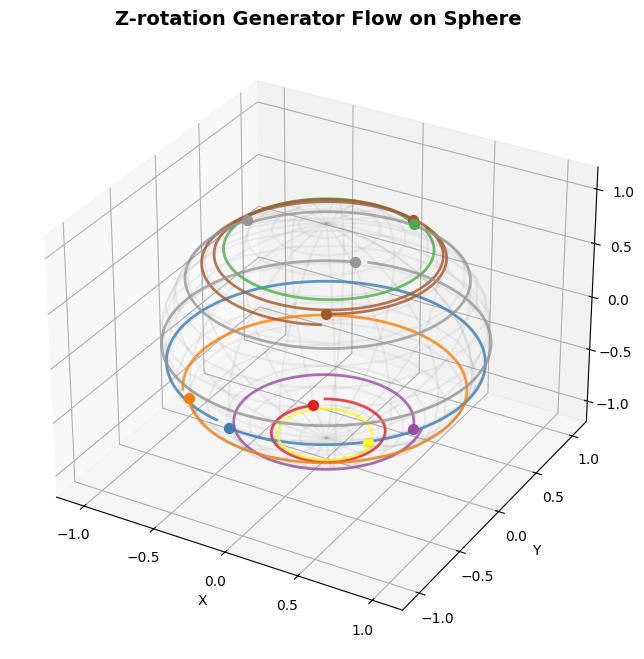

✅ This shows how our target symmetry behaves on the sphere surface


In [112]:
# Visualize Z-rotation generator (our target symmetry) in detail
z_rotation = so3_generators[2]

print("📊 2D Projections of Z-rotation Generator")
plot_2d_projections_so3(z_rotation, "Z-rotation SO(3) Generator (Target Symmetry)")

print("📈 Streamlines showing flow patterns")
plot_streamlines_on_sphere(z_rotation, title="Z-rotation Generator Flow on Sphere", n_streamlines=10)

print("✅ This shows how our target symmetry behaves on the sphere surface")

## 🔄 Prepare Dataloaders

In [113]:
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

# Split data
split_idx = 2 * n_trials // 3
y_train, z_train = y[:split_idx], z[:split_idx]
y_valid, z_valid = y[split_idx:], z[split_idx:]

print(f"Training data: {y_train.shape}")
print(f"Validation data: {y_valid.shape}")

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), 
    batch_size=cfg.batch_sz, 
    shuffle=True, 
    collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), 
    batch_size=cfg.batch_sz, 
    shuffle=False, 
    collate_fn=collate_fn
)

Training data: torch.Size([666, 75, 150])
Validation data: torch.Size([334, 75, 150])


## 🧱 Define Model Components

In [114]:
# Likelihood (3D)
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics (learnable, 3D)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition (3D)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders (3D)
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

print("✅ 3D model components created")

✅ 3D model components created


## 🎯 Define SO(3) Target Vector Fields

We'll create SO(3) rotation generators and combine them for regularization.

In [115]:
# Create SO(3) generators
so3_generators = create_so3_generators()

# Test the generators
test_points = torch.randn(5, 3)
print(f"Testing SO(3) generators with points shape: {test_points.shape}")

for i, gen in enumerate(so3_generators):
    output = gen(test_points)
    print(f"  Generator {i} ({'xyz'[i]}-rotation): {output.shape}")

# For this demo, we'll use z-rotation as the primary symmetry
# (analogous to rotation in the 2D ring attractor)
target_vector_field = so3_generators[2]  # z-rotation

print(f"\n✅ Using z-rotation as target symmetry")
print(f"Target field test output shape: {target_vector_field(test_points).shape}")

Testing SO(3) generators with points shape: torch.Size([5, 3])
  Generator 0 (x-rotation): torch.Size([5, 3])
  Generator 1 (y-rotation): torch.Size([5, 3])
  Generator 2 (z-rotation): torch.Size([5, 3])

✅ Using z-rotation as target symmetry
Target field test output shape: torch.Size([5, 3])


## 🧠 Create Regularized State Space Model

We use the existing `RegularizedSSM` - it works with any dimension!

In [116]:
# Regularization parameters
lambda_lie = 1e-4       # Weight for Lie derivative regularization
lambda_curvature = 0.0   # Weight for curvature regularization (optional)

# Create regularized SSM with SO(3) symmetry
regularized_ssm = RegularizedSSM(
    dynamics_mod=dynamics_mod,
    likelihood_pdf=likelihood_pdf, 
    initial_c_pdf=initial_condition_pdf,
    backward_encoder=backward_encoder, 
    local_encoder=local_encoder, 
    nl_filter=nl_filter,
    target_vector_field=target_vector_field,  # SO(3) z-rotation
    lambda_lie=lambda_lie,
    lambda_curvature=lambda_curvature,
    lie_normalize="yang",
    curvature_order=1,
    device=cfg.device
)

print(f"✅ 3D Sphere RegularizedSSM created with:")
print(f"  Latent dimensions: {cfg.n_latents}")
print(f"  Regularization: SO(3) z-rotation")
print(f"  λ_lie = {lambda_lie}")
print(f"  λ_curvature = {lambda_curvature}")
print(f"  Device: {cfg.device}")

✅ 3D Sphere RegularizedSSM created with:
  Latent dimensions: 3
  Regularization: SO(3) z-rotation
  λ_lie = 0.0001
  λ_curvature = 0.0
  Device: cpu


## 🔬 Test Forward Pass

In [117]:
# Test forward pass with a small batch
test_batch = y_train[:2]  # Use 2 trials
print(f"Testing with batch shape: {test_batch.shape}")

with torch.no_grad():
    loss, z_samples, stats = regularized_ssm(test_batch, cfg.n_samples)

print(f"\n✅ Forward pass successful!")
print(f"  Total loss: {loss.item():.6f}")
print(f"  ELBO loss: {stats['elbo_loss'].item():.6f}")
print(f"  Lie loss (SO3 z-rot): {stats['lie_loss'].item():.6f}")
print(f"  Curvature loss: {stats['curvature_loss'].item():.6f}")
print(f"  KL loss: {stats['kl'].sum(dim=-1).mean():.6f}")
print(f"  Latent samples shape: {z_samples.shape}")
print(f"  Latent dims: {z_samples.shape[-1]} (should be 3)")

Testing with batch shape: torch.Size([2, 75, 150])

✅ Forward pass successful!
  Total loss: 20798.992188
  ELBO loss: 20798.755859
  Lie loss (SO3 z-rot): 2355.268311
  Curvature loss: 0.000000
  KL loss: 0.113248
  Latent samples shape: torch.Size([5, 2, 75, 3])
  Latent dims: 3 (should be 3)


## 🚀 Train the 3D Regularized Model

In [118]:
# Create the Lightning module (reuses existing RegularizedLightningSSM)
seq_vae = RegularizedLightningSSM(regularized_ssm, cfg)
print("✅ Lightning module created")

✅ Lightning module created


In [119]:
# Set up logging and callbacks
csv_logger = CSVLogger(
    'logs_3d_sphere/', 
    name=f'so3_lie_{lambda_lie}_curv_{lambda_curvature}', 
    version='sphere_3d'
)

ckpt_callback = ModelCheckpoint(
    save_top_k=3, 
    monitor='valid_loss', 
    mode='min',
    dirpath='ckpts_3d_sphere/', 
    filename='{epoch:02d}_{valid_loss:.4f}'
)

early_stop_callback = EarlyStopping(
    monitor="valid_elbo",
    min_delta=0.001, 
    patience=10, 
    verbose=True, 
    mode="min"
)

timer = Timer()

# Create trainer
trainer = pl.Trainer(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=1.0,
    default_root_dir='lightning_3d_sphere/',
    callbacks=[ckpt_callback, timer, early_stop_callback],
    accelerator=cfg.device,
    logger=csv_logger,
    log_every_n_steps=10
)

print("🚀 Starting 3D sphere training...")
print(f"   Max epochs: {cfg.n_epochs}")
print(f"   Regularization: SO(3) z-rotation")
print(f"   Checkpoints: ckpts_3d_sphere/")
print(f"   Logs: logs_3d_sphere/")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


🚀 Starting 3D sphere training...
   Max epochs: 25
   Regularization: SO(3) z-rotation
   Checkpoints: ckpts_3d_sphere/
   Logs: logs_3d_sphere/


In [120]:
# Start training
trainer.fit(
    model=seq_vae, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader
)

# Save best model path
torch.save(ckpt_callback.best_model_path, 'ckpts_3d_sphere/best_model_path.pt')
print(f"\n✅ Training completed!")
print(f"   Best model: {ckpt_callback.best_model_path}")
print(f"   Training time: {timer.time_elapsed('train'):.1f}s")
print(f"   Validation time: {timer.time_elapsed('validate'):.1f}s")


  | Name | Type           | Params
----------------------------------------
0 | ssm  | RegularizedSSM | 49.2 K
----------------------------------------
48.6 K    Trainable params
600       Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved. New best score: 25553.600


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 560.936 >= min_delta = 0.001. New best score: 24992.664


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 208.973 >= min_delta = 0.001. New best score: 24783.691


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 810.898 >= min_delta = 0.001. New best score: 23972.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 1051.707 >= min_delta = 0.001. New best score: 22921.086


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 2953.053 >= min_delta = 0.001. New best score: 19968.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 5497.894 >= min_delta = 0.001. New best score: 14470.140


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 2010.439 >= min_delta = 0.001. New best score: 12459.700


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 1530.308 >= min_delta = 0.001. New best score: 10929.393


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 1051.021 >= min_delta = 0.001. New best score: 9878.372


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 555.370 >= min_delta = 0.001. New best score: 9323.002


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 367.923 >= min_delta = 0.001. New best score: 8955.079


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 439.037 >= min_delta = 0.001. New best score: 8516.042


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 472.165 >= min_delta = 0.001. New best score: 8043.877


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 803.048 >= min_delta = 0.001. New best score: 7240.829


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 1696.858 >= min_delta = 0.001. New best score: 5543.971


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 972.968 >= min_delta = 0.001. New best score: 4571.002


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 106.865 >= min_delta = 0.001. New best score: 4464.137


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 70.612 >= min_delta = 0.001. New best score: 4393.525


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 114.122 >= min_delta = 0.001. New best score: 4279.403


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 89.531 >= min_delta = 0.001. New best score: 4189.872


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 47.019 >= min_delta = 0.001. New best score: 4142.854


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 30.582 >= min_delta = 0.001. New best score: 4112.271
`Trainer.fit` stopped: `max_epochs=25` reached.



✅ Training completed!
   Best model: /Users/artliang/Documents/symm_reg/in_progress/ckpts_3d_sphere/epoch=24_valid_loss=4112.2822.ckpt
   Training time: 4034.0s
   Validation time: 27.8s


## 📊 Load Best Model and Analyze Results

In [127]:
# Load the best model
best_model_path = torch.load('ckpts_3d_sphere/best_model_path.pt')
seq_vae = RegularizedLightningSSM.load_from_checkpoint(
    best_model_path, 
    regularized_ssm=regularized_ssm, 
    cfg=cfg
)
seq_vae = seq_vae.to('cpu')
seq_vae.eval()

print("✅ Best model loaded and ready for analysis")

✅ Best model loaded and ready for analysis


In [122]:
# Infer latent trajectories
with torch.no_grad():
    _, z_inferred_samples, _ = seq_vae.ssm(y, cfg.n_samples)
    z_inferred = z_inferred_samples.mean(dim=0)

print(f"✅ Inferred latents from observations")
print(f"   Inferred shape: {z_inferred.shape}")
print(f"   True shape: {z.shape}")

# Compute recovery metrics
mse = torch.mean((z_inferred - z)**2).item()
correlation = torch.corrcoef(torch.stack([z.flatten(), z_inferred.flatten()]))[0, 1].item()

print(f"📊 3D Recovery metrics:")
print(f"   MSE: {mse:.6f}")
print(f"   Correlation: {correlation:.4f}")

✅ Inferred latents from observations
   Inferred shape: torch.Size([1000, 75, 3])
   True shape: torch.Size([1000, 75, 3])
📊 3D Recovery metrics:
   MSE: 0.013611
   Correlation: 0.9838


## 🌟 Visualize 3D Learned vs Target Dynamics

In [123]:
# Generate autonomous trajectories from learned 3D dynamics
n_rollout_trials = 15
n_rollout_time = 40

# Initial conditions around sphere
from sphere_dynamics import sample_sphere_initial_conditions
z_0_sphere = sample_sphere_initial_conditions(n_rollout_trials, radius_range=(0.3, 1.8))
z_0 = z_0_sphere.unsqueeze(0)  # Add sample dimension

# Predict forward
z_predicted = seq_vae.ssm.predict_forward(z_0, n_rollout_time).detach()

print(f"Generated autonomous trajectories:")
print(f"  Initial conditions: {z_0.shape}")
print(f"  Predicted trajectories: {z_predicted.shape}")

Generated autonomous trajectories:
  Initial conditions: torch.Size([1, 15, 3])
  Predicted trajectories: torch.Size([1, 15, 40, 3])


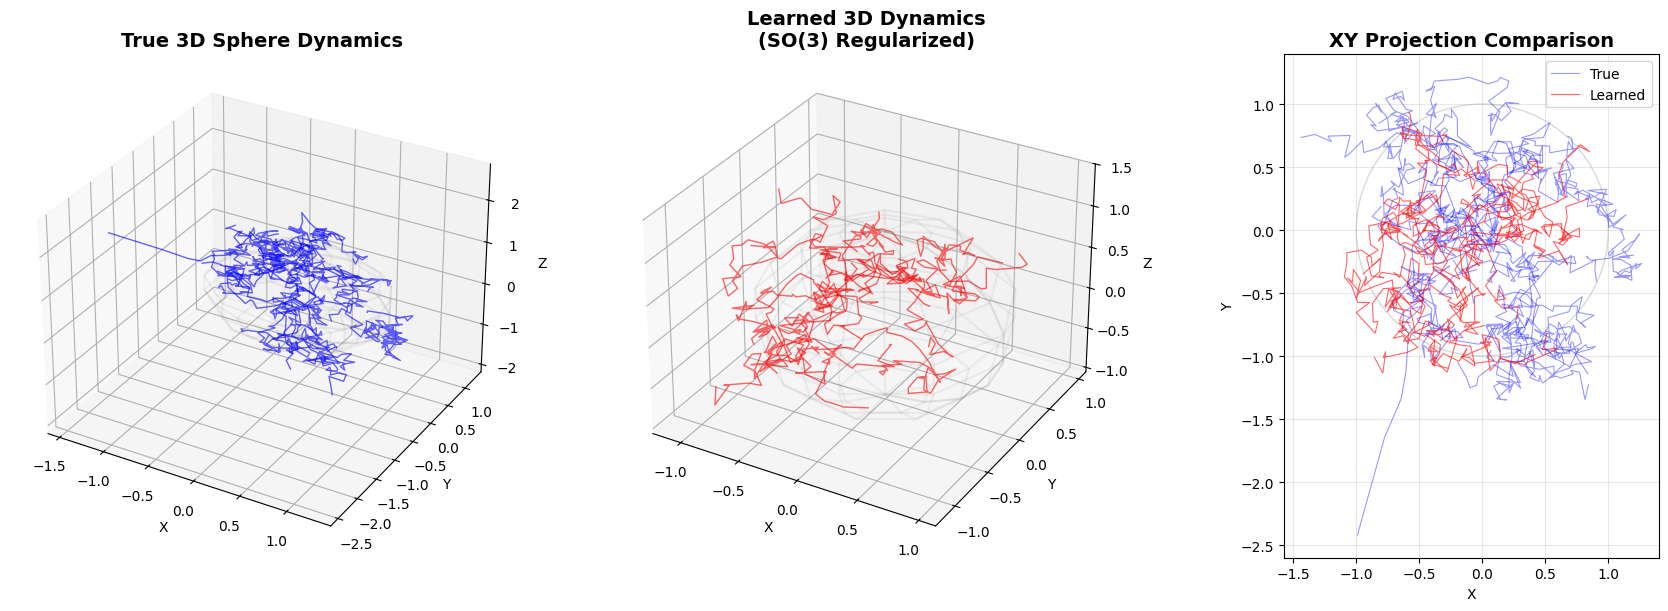

In [124]:
# Create 3D comparison visualization
fig = plt.figure(figsize=(18, 6))

# 1. True dynamics + true trajectories
ax1 = fig.add_subplot(131, projection='3d')
for i in range(15):
    traj = z[i, :, :].cpu()
    ax1.plot(traj[:, 0], traj[:, 1], traj[:, 2], 'b-', alpha=0.6, linewidth=1)

# Draw unit sphere
u = np.linspace(0, 2 * np.pi, 10)
v = np.linspace(0, np.pi, 10)
sphere_x = np.outer(np.cos(u), np.sin(v))
sphere_y = np.outer(np.sin(u), np.sin(v))
sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(sphere_x, sphere_y, sphere_z, alpha=0.1, color='gray')

ax1.set_title("True 3D Sphere Dynamics", fontsize=14, fontweight='bold')
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# 2. Learned dynamics + predicted trajectories
ax2 = fig.add_subplot(132, projection='3d')
for i in range(n_rollout_trials):
    traj = z_predicted[0, i, :, :].cpu()
    ax2.plot(traj[:, 0], traj[:, 1], traj[:, 2], 'r-', alpha=0.6, linewidth=1)

ax2.plot_wireframe(sphere_x, sphere_y, sphere_z, alpha=0.1, color='gray')
ax2.set_title("Learned 3D Dynamics\n(SO(3) Regularized)", fontsize=14, fontweight='bold')
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

# 3. Show XY projection comparison
ax3 = fig.add_subplot(133)
# True trajectories
for i in range(15):
    traj = z[i, :, :].cpu()
    ax3.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.4, linewidth=0.8, label='True' if i == 0 else '')

# Predicted trajectories
for i in range(n_rollout_trials):
    traj = z_predicted[0, i, :, :].cpu()
    ax3.plot(traj[:, 0], traj[:, 1], 'r-', alpha=0.6, linewidth=0.8, label='Learned' if i == 0 else '')

circle = plt.Circle((0, 0), 1, fill=False, color='gray', alpha=0.3)
ax3.add_patch(circle)
ax3.set_title("XY Projection Comparison", fontsize=14, fontweight='bold')
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_aspect('equal')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [128]:
%matplotlib notebook

## 📊 Final Loss Analysis

In [125]:
# Get final loss components on validation set
final_losses = seq_vae.ssm.get_loss_components(y_valid, cfg.n_samples)

print("🔍 Final Loss Component Analysis (3D Sphere + SO(3)):")
print(f"  Total Loss:      {final_losses['total_loss']:.6f}")
print(f"  ELBO Loss:       {final_losses['elbo_loss']:.6f}")
print(f"  Lie Loss (SO3):  {final_losses['lie_loss']:.6f}")
print(f"  Curvature Loss:  {final_losses['curvature_loss']:.6f}")
print(f"  Total Reg Loss:  {final_losses['total_reg_loss']:.6f}")

# Create a bar plot of loss components
components = ['ELBO', 'Lie (SO3)', 'Curvature']
values = [final_losses['elbo_loss'], final_losses['lie_loss'], final_losses['curvature_loss']]
colors = ['blue', 'red', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(components, values, color=colors, alpha=0.7)
plt.title('Final Loss Components (3D Sphere + SO(3))', fontsize=14, fontweight='bold')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# plt.tight_layout()
# plt.show()

🔍 Final Loss Component Analysis (3D Sphere + SO(3)):
  Total Loss:      4091.117676
  ELBO Loss:       4091.109619
  Lie Loss (SO3):  81.657867
  Curvature Loss:  0.000000
  Total Reg Loss:  0.008166


🔥 Comprehensive Learned vs Target SO(3) Field Comparison


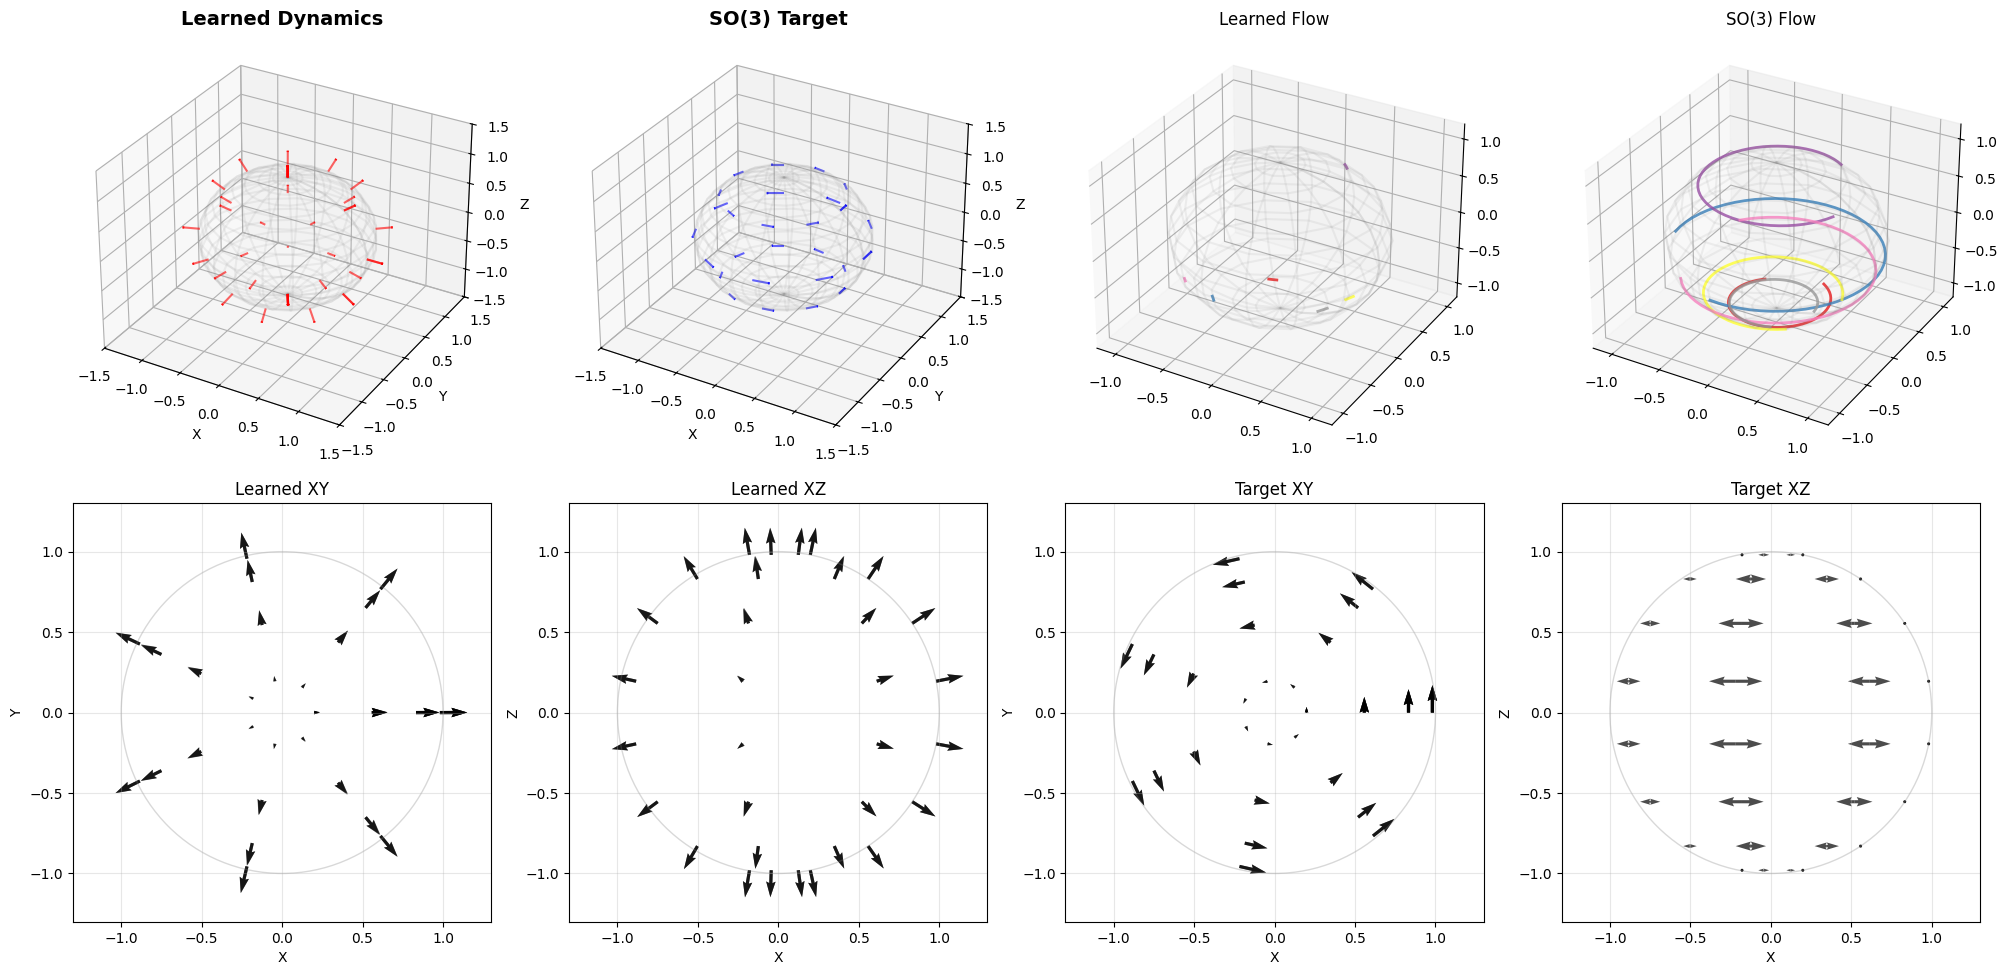

🎯 Key insights from this comparison:
  • Top row: 3D quiver plots show vector field directions on sphere
  • Middle row: Streamlines reveal flow patterns and closed orbits
  • Bottom row: 2D projections make 3D structure easier to interpret
  • Left columns: What the model learned from data + regularization
  • Right columns: Target SO(3) symmetry we regularized toward

✨ The learned dynamics should resemble the target field where regularization was effective!


In [126]:
# 🌐 Compare Learned vs Target SO(3) Dynamics 
print("🔥 Comprehensive Learned vs Target SO(3) Field Comparison")

# Compare learned dynamics with target SO(3) field
visualize_so3_vs_learned_dynamics(
    learned_dynamics_fn=seq_vae.ssm.dynamics_mod.mean_fn,
    so3_field_fn=target_vector_field  # z-rotation generator
)

print("🎯 Key insights from this comparison:")
print("  • Top row: 3D quiver plots show vector field directions on sphere")
print("  • Middle row: Streamlines reveal flow patterns and closed orbits") 
print("  • Bottom row: 2D projections make 3D structure easier to interpret")
print("  • Left columns: What the model learned from data + regularization")
print("  • Right columns: Target SO(3) symmetry we regularized toward")
print("\n✨ The learned dynamics should resemble the target field where regularization was effective!")

## ✅ 3D Sphere Training Complete!

### Summary

Successfully trained a 3D sphere attractor with SO(3) rotational symmetry regularization using:

1. **3D Sphere Dynamics**: `x' = x * (1 - ||x||)` attracts to unit sphere
2. **SO(3) Regularization**: z-rotation generator enforces rotational symmetry  
3. **RBF Perturbations**: 3D structured noise for realistic dynamics
4. **Existing Infrastructure**: Reused `RegularizedSSM` with no modifications needed!

### Key Advantages:
- **Dimension Agnostic**: The regularization framework scales naturally to 3D
- **Modular Design**: Easy to swap in different SO(3) generators
- **Reusable Code**: Minimal changes from 2D ring attractor approach

### Next Steps:
- Experiment with different SO(3) generator combinations
- Try multiple generators simultaneously (full SO(3) regularization)
- Compare against non-regularized 3D sphere attractor
- Analyze learned manifold geometry